In [1]:
import os 
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout 
from keras.callbacks import EarlyStopping 
from tensorflow.keras.callbacks import TensorBoard
from keras_tuner.tuners import RandomSearch
from tqdm import tqdm
import keras
import pickle


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


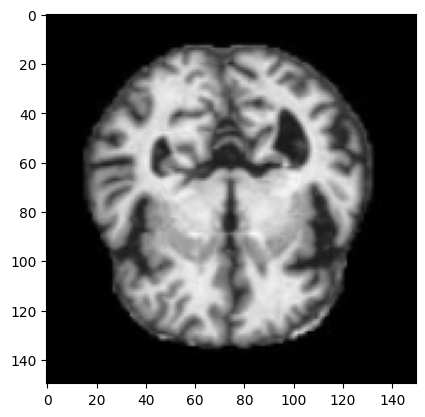

In [2]:
img="/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/Mild Impairment/MildImpairment (1).jpg"
img = cv2.imread(img)
img=cv2.resize(img,(150,150))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


In [3]:
img_size=150
DATADIR = '//kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train'
CATEGORIES = ["Mild Impairment", "Moderate Impairment","No Impairment","Very Mild Impairment"]
x_train = []
y_train = []
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    class_num = CATEGORIES.index(category) 
    for img in tqdm(os.listdir(path)): 
        img_array = cv2.imread(os.path.join(path,img)) 
        new_array = cv2.resize(img_array, (img_size, img_size)) 
        x_train.append(new_array)
        y_train.append(class_num)  

100%|██████████| 2560/2560 [00:09<00:00, 264.72it/s]


In [4]:
DATADIR = '//kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test'
x_test = []
y_test = []
for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    class_num = CATEGORIES.index(category) 
    for img in tqdm(os.listdir(path)): 
        img_array = cv2.imread(os.path.join(path,img)) 
        new_array = cv2.resize(img_array, (img_size, img_size)) 
        x_test.append(new_array)
        y_test.append(class_num)  

100%|██████████| 448/448 [00:01<00:00, 288.99it/s]


In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

def data_augmentation(x,y):
    # Initialize lists to store augmented data
    augmented_data = []
    augmented_label = []
    # Set the batch size
    batch_size = 32
    # Create a generator for augmented data
    augmentation_generator = datagen.flow(x, y, batch_size=batch_size, shuffle=False)
    # Determine the number of batches needed
    num_batches = len(x) // batch_size
    # Apply data augmentation in a loop
    for _ in range(num_batches):
        batch_images, batch_labels = augmentation_generator.next()
        # Append the augmented images and labels to the lists
        augmented_data.append(batch_images)
        augmented_label.append(batch_labels)
    # Convert lists to numpy arrays
    augmented_data = np.concatenate(augmented_data)
    augmented_label = np.concatenate(augmented_label)
    # Concatenate original and augmented data
    x = np.concatenate([x, augmented_data])
    y = np.concatenate([y, augmented_label])
    return x,y
    
    




In [6]:
import random 

x_train = np.array(x_train)
y_train = np.array(y_train)

print("X_train shape before augmentation:", x_train.shape)
print("y_train shape before augmentation:", y_train.shape)

# Shuffle the dataset
num_samples = len(x_train)
indices = np.random.permutation(num_samples)
x_train = x_train[indices]
y_train = y_train[indices]


X_train shape before augmentation: (10240, 150, 150, 3)
y_train shape before augmentation: (10240,)


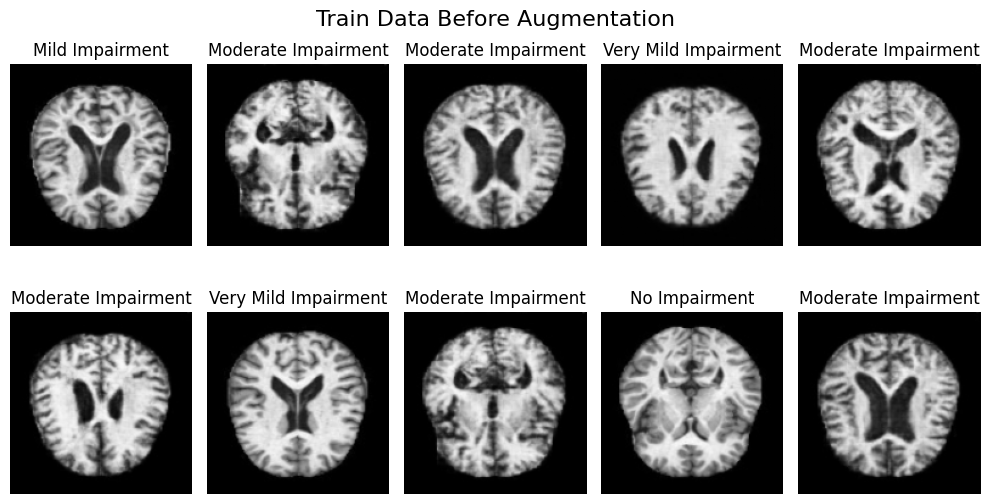

In [7]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

for n, i in enumerate(range(0, 10)):
    # Normalize the image to be in the range [0, 1]
    img = x_train[i] / 255.0

    plt.subplot(2, 5, n + 1, aspect='equal')  # Set aspect ratio to equal
    plt.imshow(img)
    plt.axis('off')
    plt.title(CATEGORIES[y_train[i]])

plt.suptitle("Train Data Before Augmentation", fontsize=16, y=0.92)
plt.tight_layout()

plt.show()




In [8]:
x_train,y_train = data_augmentation(x_train,y_train)
# Check the shapes of augmented datasets
print("X_train shape after augmentation:", x_train.shape)
print("y_train shape after augmentation:", y_train.shape)

X_train shape after augmentation: (20480, 150, 150, 3)
y_train shape after augmentation: (20480,)


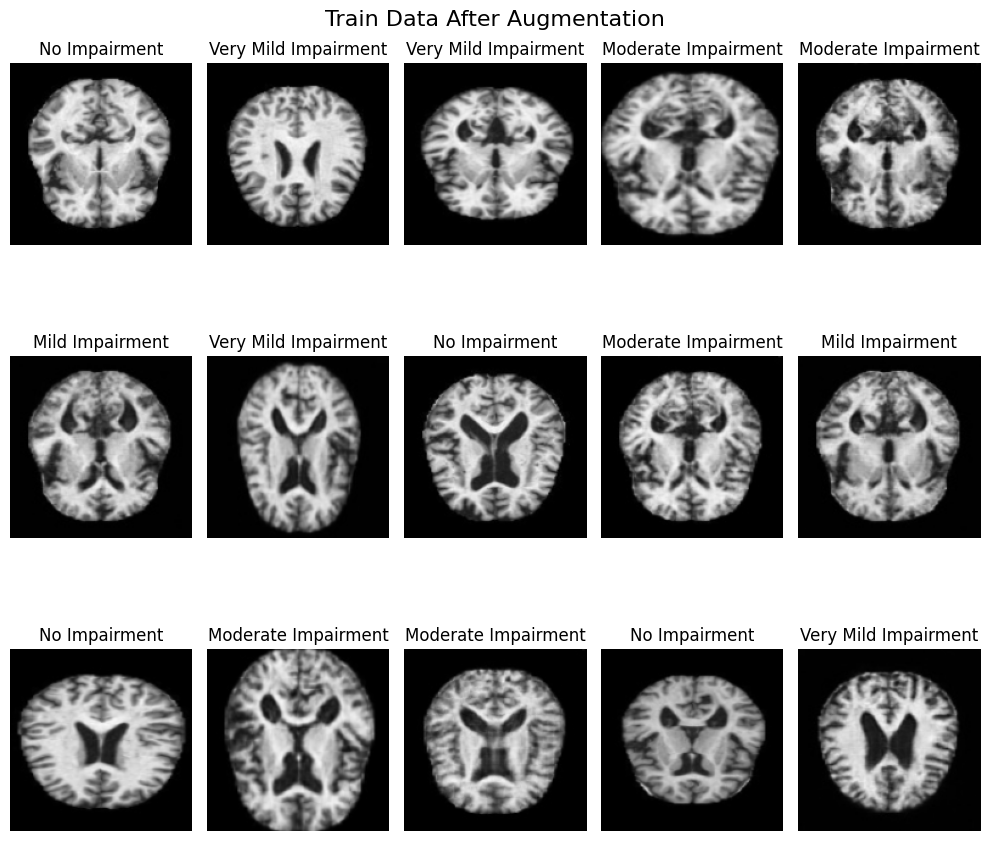

In [9]:
plt.figure(figsize=(10, 10))  # Adjust the figure size if needed

for n, i in enumerate(list(np.random.randint(0, len(x_train), 15))):
    # Normalize the image to be in the range [0, 1]
    img = x_train[i] / 255.0

    plt.subplot(3, 5, n + 1, aspect='equal')  # Set aspect ratio to equal
    plt.imshow(img)
    plt.axis('off')
    plt.title(CATEGORIES[y_train[i]])

plt.suptitle("Train Data After Augmentation", fontsize=16, y=0.92)
plt.tight_layout()
plt.show()

In [10]:
x_test = np.array(x_test)
y_test = np.array(y_test)

# befor data augmentation
print("X_test shape before augmentation:", x_test.shape)
print("y_test shape before augmentation:", y_test.shape)


# Shuffle the dataset
num_samples = len(x_test)
indices = np.random.permutation(num_samples)
x_test = x_test[indices]
y_test = y_test[indices]


X_test shape before augmentation: (1279, 150, 150, 3)
y_test shape before augmentation: (1279,)


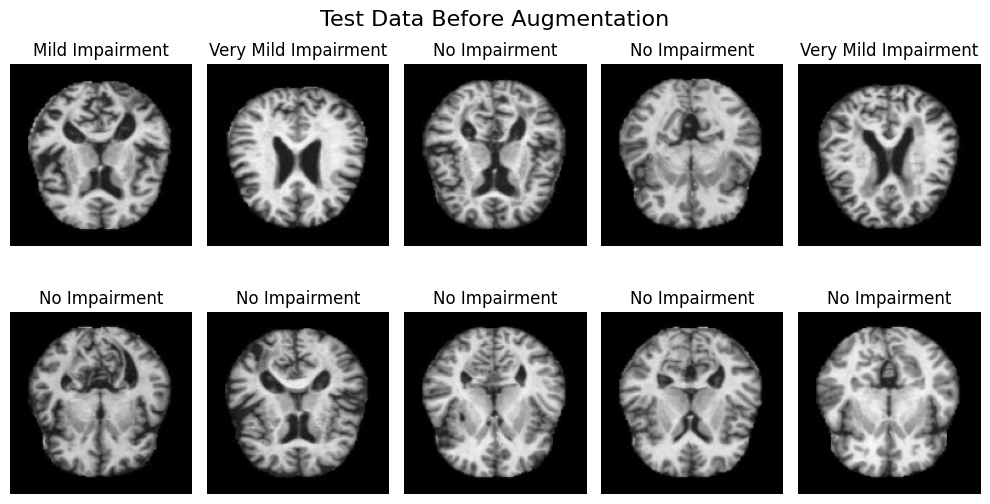

In [11]:
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

for n, i in enumerate(range(0, 10)):
    # Normalize the image to be in the range [0, 1]
    img = x_test[i] / 255.0

    plt.subplot(2, 5, n + 1, aspect='equal')  # Set aspect ratio to equal
    plt.imshow(img)
    plt.axis('off')
    plt.title(CATEGORIES[y_test[i]])

plt.suptitle("Test Data Before Augmentation", fontsize=16, y=0.92)
plt.tight_layout()

plt.show()




In [12]:
x_test,y_test = data_augmentation(x_test,y_test)
print("X_test shape after augmentation:", x_test.shape)
print("y_test shape after augmentation:", y_test.shape)

X_test shape after augmentation: (2527, 150, 150, 3)
y_test shape after augmentation: (2527,)


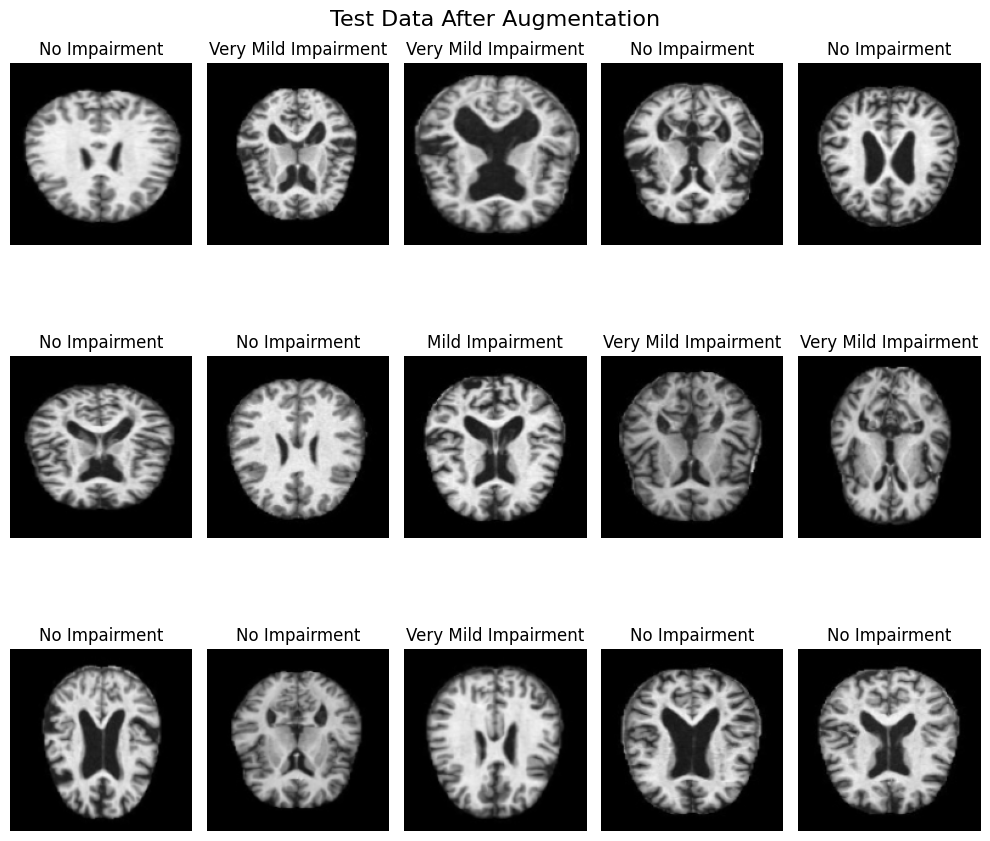

In [13]:
plt.figure(figsize=(10, 10))  # Adjust the figure size if needed

for n, i in enumerate(list(np.random.randint(0, len(x_test), 15))):
    # Normalize the image to be in the range [0, 1]
    img = x_test[i] / 255.0

    plt.subplot(3, 5, n + 1, aspect='equal')  # Set aspect ratio to equal
    plt.imshow(img)
    plt.axis('off')
    plt.title(CATEGORIES[y_test[i]])

plt.suptitle("Test Data After Augmentation", fontsize=16, y=0.92)
plt.tight_layout()

plt.show()




In [14]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# Normalize the pixel values to the range [0, 1]
x_train = x_train / 255.0
# Convert labels to one-hot encoding
y_train = convert_to_one_hot(y_train, 4).T

# Normalize the pixel values to the range [0, 1]
x_test = x_test / 255.0
# Convert labels to one-hot encoding
y_test = convert_to_one_hot(y_test, 4).T


In [15]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.3)

In [16]:

# Save data to pickle files
def save_data_to_pickle(x, y, filename):
    with open(filename, 'wb') as f:
        pickle.dump((x, y), f)
# Save your datasets
save_data_to_pickle(x_train, y_train, 'x_train_y_train.pkl')
save_data_to_pickle(x_test, y_test, 'x_test_y_test.pkl')
save_data_to_pickle(x_valid, y_valid, 'x_valid_y_valid.pkl')




In [17]:
# Load data from pickle files
def load_data_from_pickle(filename):
    with open(filename, 'rb') as f:
        x, y = pickle.load(f)
    return x, y
# Load your datasets
x_train, y_train = load_data_from_pickle('x_train_y_train.pkl')
x_test, y_test = load_data_from_pickle('x_test_y_test.pkl')
x_valid, y_valid = load_data_from_pickle('x_valid_y_valid.pkl')

# Hyperparameter tuning of VGG19

In [18]:
from keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam, SGD, Adamax, RMSprop, Nadam,Adagrad

input_shape = (img_size, img_size, 3)

def build_model(hp):
    layer_1 = hp.Int(name="layer_1", min_value=32, max_value=512, step=32)
    layer_2 = hp.Int(name="layer_2", min_value=32, max_value=512, step=32) 
    layer_3 = hp.Int(name="layer_3", min_value=32, max_value=512, step=32)


    dropout_1 = hp.Float(name="dropout_1", min_value=0.0, max_value=0.5, step=0.1)
    dropout_2 = hp.Float(name="dropout_2", min_value=0.0, max_value=0.5, step=0.1)
    dropout_3 = hp.Float(name="dropout_3", min_value=0.0, max_value=0.5, step=0.1) 
    
    model = Sequential()
    model_vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    for layer in model_vgg19.layers:
        model.add(layer)
    for layer in model.layers:
        layer.trainable = False  # Not trainable weights   
    model.add(Flatten())
    
    model.add(Dense(layer_1,activation='relu', input_shape = input_shape))
    model.add(Dropout(dropout_1))
    model.add(Dense(layer_2,activation='relu'))
    model.add(Dropout(dropout_2))
    model.add(Dense(layer_3,activation='relu'))
    model.add(Dropout(dropout_3))
    model.add(Dense(4, activation='softmax'))

    loss_type = hp.Choice(name="loss_type", values=['categorical_crossentropy', 'mean_squared_error'])
    optimizer_type = hp.Choice(name="optimizer_type", values=['adam', 'nadam', 'adamax'])
    learning_rate = hp.Choice('learning_rate', values=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate= learning_rate)
    elif optimizer_type == 'adamax':
        optimizer = Adamax(learning_rate = learning_rate)
    elif optimizer_type == 'nadam':
        optimizer = Nadam(learning_rate = learning_rate)
    model.compile(optimizer=optimizer,
                  loss= loss_type,
                  metrics=['accuracy'])
    return model

In [19]:
tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = 'vgg19',
    project_name ='Alzheimer_tuning'
)

80134624/80134624 [==============================] - 0s 0us/step


In [20]:
stop_early = EarlyStopping(monitor='val_loss', patience = 3)
tuner.search(x_train, y_train, validation_data=(x_valid,y_valid), epochs=60,batch_size = 16,  callbacks=[stop_early])


Trial 10 Complete [00h 02m 21s]
val_accuracy: 0.2449544221162796

Best val_accuracy So Far: 0.9147135615348816
Total elapsed time: 02h 19m 18s


In [21]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'layer_1': 480, 'layer_2': 512, 'layer_3': 320, 'dropout_1': 0.4, 'dropout_2': 0.1, 'dropout_3': 0.0, 'loss_type': 'mean_squared_error', 'optimizer_type': 'adam', 'learning_rate': 1e-05}


In [22]:
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

In [23]:
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=60, batch_size=16, callbacks=[stop_early])
history

Epoch 1/60
896/896 [==============================] - 36s 38ms/step - loss: 0.1710 - accuracy: 0.4255 - val_loss: 0.1337 - val_accuracy: 0.6283
Epoch 2/60
896/896 [==============================] - 30s 33ms/step - loss: 0.1300 - accuracy: 0.6064 - val_loss: 0.1051 - val_accuracy: 0.6898
Epoch 3/60
896/896 [==============================] - 30s 33ms/step - loss: 0.1106 - accuracy: 0.6705 - val_loss: 0.0937 - val_accuracy: 0.7267
Epoch 4/60
896/896 [==============================] - 30s 33ms/step - loss: 0.0998 - accuracy: 0.7041 - val_loss: 0.0872 - val_accuracy: 0.7443
Epoch 5/60
896/896 [==============================] - 30s 33ms/step - loss: 0.0916 - accuracy: 0.7317 - val_loss: 0.0806 - val_accuracy: 0.7635
Epoch 6/60
896/896 [==============================] - 30s 33ms/step - loss: 0.0855 - accuracy: 0.7471 - val_loss: 0.0768 - val_accuracy: 0.7743
Epoch 7/60
896/896 [==============================] - 30s 33ms/step - loss: 0.0808 - accuracy: 0.7641 - val_loss: 0.0739 - val_accuracy:

# Visualize loss and accuracy value during training in VGG19 model

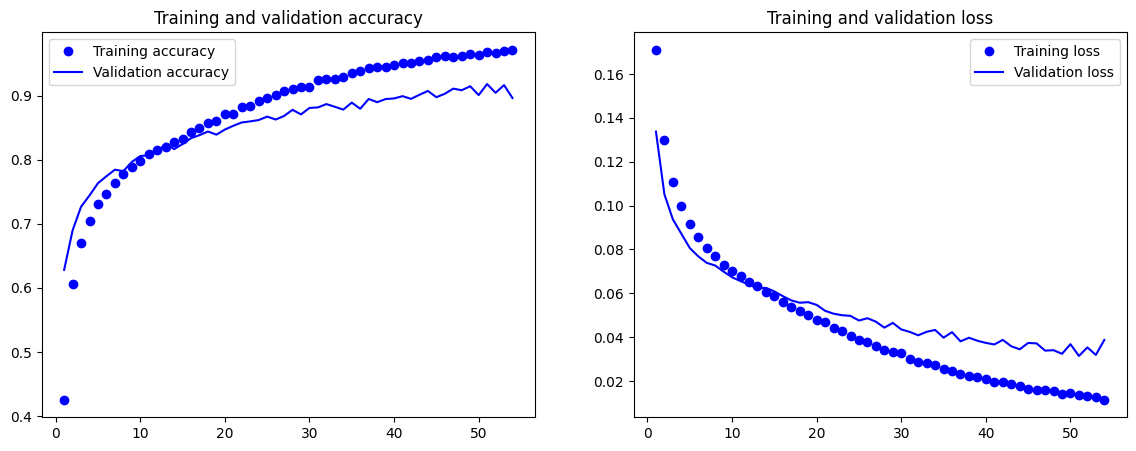

In [33]:

plt.figure(figsize=(14, 5))  

# Plotting accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()


In [24]:
model.save('vgg19_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Test accuracy and loss of VGG19 model

In [25]:
from keras.models import load_model

trained_model = 'vgg19_model.h5'
loaded_model = load_model(trained_model)
eval_result = loaded_model.evaluate(x_test, y_test)
# Print the evaluation result
print("Loss:", eval_result[0])
print("Accuracy:", (eval_result[1])*100,"%")


79/79 [==============================] - 6s 55ms/step - loss: 0.0802 - accuracy: 0.7816
Loss: 0.08017285168170929
Accuracy: 78.155916929245 %


# Confusion matrix of VGG19

79/79 [==============================] - 3s 41ms/step


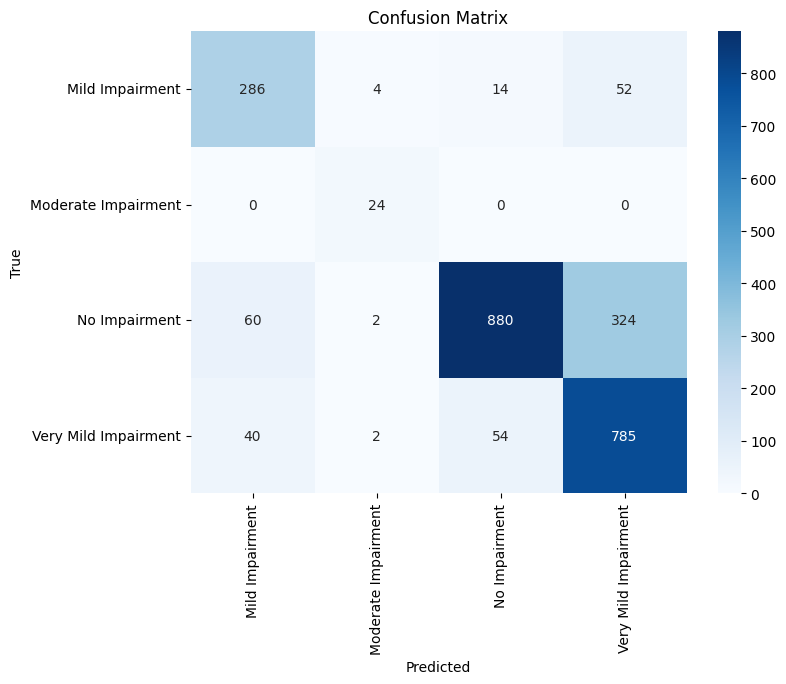

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Make predictions on the test set
y_pred = loaded_model.predict(x_test)
y_pred_vgg19 = np.argmax(y_pred, axis=1)
y_true_vgg19 = np.argmax(y_test, axis=1)

# Define your class labels
CATEGORIES = ["Mild Impairment", "Moderate Impairment","No Impairment","Very Mild Impairment"]

# Confusion Matrix
conf_mat = confusion_matrix(y_true_vgg19, y_pred_vgg19)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Classification Report
class_report = classification_report(y_true_vgg19, y_pred_vgg19)

# Calculate Metrics
accuracy = (conf_mat[0, 0] + conf_mat[1, 1]) / np.sum(conf_mat)
precision = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[0, 1])
recall = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)


# Performance measures table of VGG19

In [73]:
from IPython.display import display

# Use true and predicted labels to calculate performance measures
class_report_vgg19 = classification_report(y_true_vgg19, y_pred_vgg19, output_dict=True)

# Convert the classification report to a DataFrame
df_class_report_vgg19 = pd.DataFrame(class_report_vgg19).transpose()

# Display the DataFrame using default styling
display(df_class_report_vgg19)


,precision,recall,f1-score,support
0,0.740933,0.803371,0.770889,356.000000
1,0.750000,1.000000,0.857143,24.000000
2,0.928270,0.695103,0.794941,1266.000000
3,0.676141,0.891033,0.768854,881.000000
accuracy,0.781559,0.781559,0.781559,0.781559
macro avg,0.773836,0.847377,0.797957,2527.000000
weighted avg,0.812284,0.781559,0.783049,2527.000000


# Hyperparameter tuning of VGG16

In [26]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, Nadam

input_shape = (img_size, img_size, 3)

def vgg16build_model(hp):
    layer_1 = hp.Int(name="layer_1", min_value=32, max_value=512, step=32)
    layer_2 = hp.Int(name="layer_2", min_value=32, max_value=512, step=32) 
    layer_3 = hp.Int(name="layer_3", min_value=32, max_value=512, step=32)


    dropout_1 = hp.Float(name="dropout_1", min_value=0.0, max_value=0.5, step=0.1)
    dropout_2 = hp.Float(name="dropout_2", min_value=0.0, max_value=0.5, step=0.1)
    dropout_3 = hp.Float(name="dropout_3", min_value=0.0, max_value=0.5, step=0.1) 
    
    model = Sequential()
    model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    for layer in model_vgg16.layers:
        model.add(layer)
    for layer in model.layers:
        layer.trainable = False  # Not trainable weights   
    model.add(Flatten())
    
    model.add(Dense(layer_1,activation='relu', input_shape = input_shape))
    model.add(Dropout(dropout_1))
    model.add(Dense(layer_2,activation='relu'))
    model.add(Dropout(dropout_2))
    model.add(Dense(layer_3,activation='relu'))
    model.add(Dropout(dropout_3))
    model.add(Dense(4, activation='softmax'))

    loss_type = hp.Choice(name="loss_type", values=['categorical_crossentropy', 'mean_squared_error'])
    optimizer_type = hp.Choice(name="optimizer_type", values=['adam', 'nadam', 'adamax','rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
    
    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate= learning_rate)
    elif optimizer_type == 'adamax':
        optimizer = Adamax(learning_rate = learning_rate)
    elif optimizer_type == 'nadam':
        optimizer = Nadam(learning_rate = learning_rate)
    elif optimizer_type == 'rmsprop':
        optimizer = RMSprop(learning_rate = learning_rate)
    model.compile(optimizer=optimizer,
                  loss= loss_type,
                  metrics=['accuracy'])
    return model

In [27]:
tuner = RandomSearch(
    vgg16build_model,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = 'vgg16Dir',
    project_name ='Alzheimer_tuning'
)

58889256/58889256 [==============================] - 0s 0us/step


In [28]:
stop_early = EarlyStopping(monitor='val_loss', patience = 3)
tuner.search(x_train, y_train, validation_data=(x_valid,y_valid), epochs=60,batch_size = 16,  callbacks=[stop_early])


Trial 10 Complete [00h 02m 05s]
val_accuracy: 0.6477864384651184

Best val_accuracy So Far: 0.9148762822151184
Total elapsed time: 02h 10m 38s


In [29]:
bestvgg16_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(bestvgg16_hps.values)

Best Hyperparameters:
{'layer_1': 352, 'layer_2': 416, 'layer_3': 416, 'dropout_1': 0.30000000000000004, 'dropout_2': 0.1, 'dropout_3': 0.4, 'loss_type': 'categorical_crossentropy', 'optimizer_type': 'adamax', 'learning_rate': 0.0001}


In [30]:
vgg16model = tuner.hypermodel.build(bestvgg16_hps)
vgg16model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)      

In [31]:
historyvgg16 = vgg16model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=60, batch_size=16, callbacks=[stop_early])
historyvgg16

Epoch 1/60
896/896 [==============================] - 31s 33ms/step - loss: 1.1055 - accuracy: 0.5005 - val_loss: 0.7590 - val_accuracy: 0.6772
Epoch 2/60
896/896 [==============================] - 26s 29ms/step - loss: 0.7536 - accuracy: 0.6626 - val_loss: 0.6413 - val_accuracy: 0.7174
Epoch 3/60
896/896 [==============================] - 26s 29ms/step - loss: 0.6314 - accuracy: 0.7194 - val_loss: 0.5392 - val_accuracy: 0.7656
Epoch 4/60
896/896 [==============================] - 26s 29ms/step - loss: 0.5684 - accuracy: 0.7517 - val_loss: 0.4948 - val_accuracy: 0.7882
Epoch 5/60
896/896 [==============================] - 26s 29ms/step - loss: 0.5254 - accuracy: 0.7742 - val_loss: 0.4654 - val_accuracy: 0.7979
Epoch 6/60
896/896 [==============================] - 26s 29ms/step - loss: 0.4859 - accuracy: 0.7919 - val_loss: 0.4461 - val_accuracy: 0.8011
Epoch 7/60
896/896 [==============================] - 26s 29ms/step - loss: 0.4514 - accuracy: 0.8076 - val_loss: 0.4372 - val_accuracy:

# Visualize loss and accuracy value during training in VGG16 model

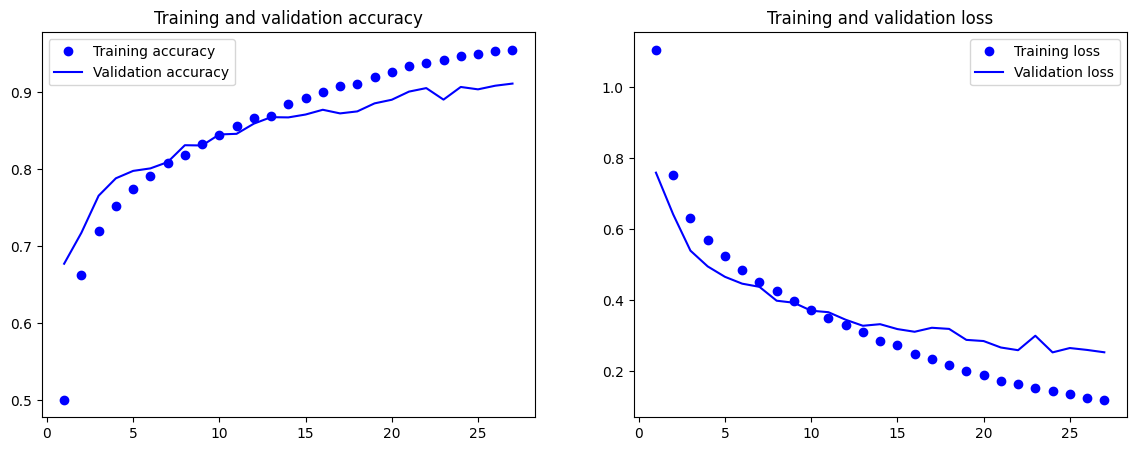

In [34]:

plt.figure(figsize=(14, 5)) 

# Plotting accuracy
plt.subplot(1, 2, 1)  
accuracy = historyvgg16.history["accuracy"]
val_accuracy = historyvgg16.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
loss = historyvgg16.history["loss"]
val_loss = historyvgg16.history["val_loss"]
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()


# Test accuracy and loss of VGG16 model

In [32]:
vgg16model.save('vgg16_model.h5')
trained_vgg16model = 'vgg16_model.h5'
loaded_vgg16model = load_model(trained_vgg16model)
result = loaded_vgg16model.evaluate(x_test, y_test)
# Print the evaluation result
print("VGG16 model Loss:", result[0])
print("VGG16 model Accuracy:", (result[1])*100,"%")

79/79 [==============================] - 3s 36ms/step - loss: 0.4735 - accuracy: 0.8346
VGG16 model Loss: 0.4735429584980011
VGG16 model Accuracy: 83.45864415168762 %


# Confusion matrix of VGG16

79/79 [==============================] - 3s 34ms/step


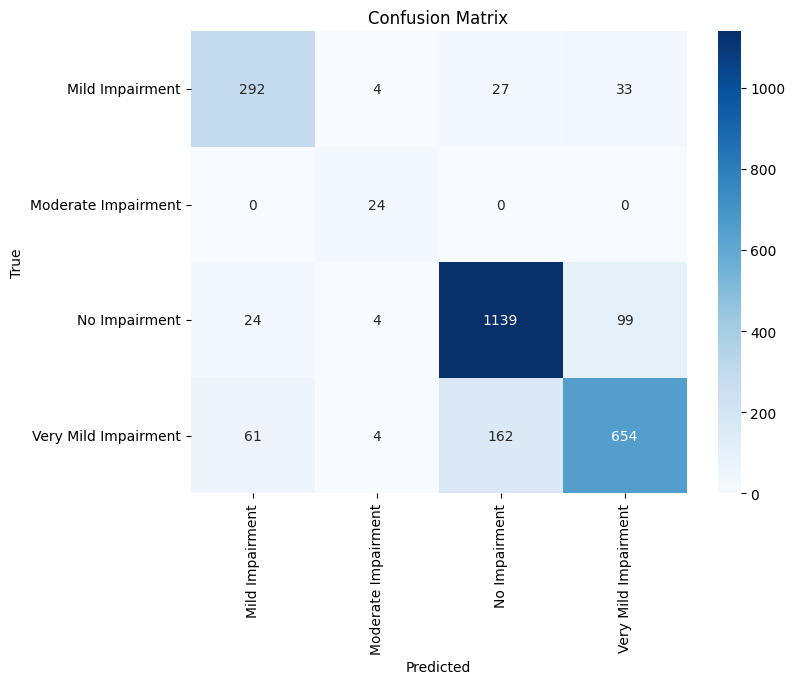

In [72]:
# Make predictions on the test set
y_pred = loaded_vgg16model.predict(x_test)
y_pred_vgg16 = np.argmax(y_pred, axis=1)
y_true_vgg16 = np.argmax(y_test, axis=1)


# Confusion Matrix
conf_mat = confusion_matrix(y_true_vgg16, y_pred_vgg16)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
class_report = classification_report(y_true_vgg16, y_pred_vgg16)

# Calculate Metrics
accuracy = (conf_mat[0, 0] + conf_mat[1, 1]) / np.sum(conf_mat)
precision = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[0, 1])
recall = conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)


# Performance measures table of VGG16

In [71]:

# Use true and predicted labels to calculate performance measures
class_report_vgg16 = classification_report(y_true_vgg16, y_pred_vgg16, output_dict=True)

# Convert the classification report to a DataFrame
df_class_report_vgg16 = pd.DataFrame(class_report_vgg16).transpose()

# Display the DataFrame using default styling
display(df_class_report_vgg16)


,precision,recall,f1-score,support
0,0.774536,0.820225,0.796726,356.000000
1,0.666667,1.000000,0.800000,24.000000
2,0.857681,0.899684,0.878180,1266.000000
3,0.832061,0.742338,0.784643,881.000000
accuracy,0.834586,0.834586,0.834586,0.834586
macro avg,0.782736,0.865562,0.814887,2527.000000
weighted avg,0.835221,0.834586,0.833352,2527.000000


# Comparison of Accuracy between VGG16 & VGG19

79/79 [==============================] - 3s 43ms/step - loss: 0.0802 - accuracy: 0.7816


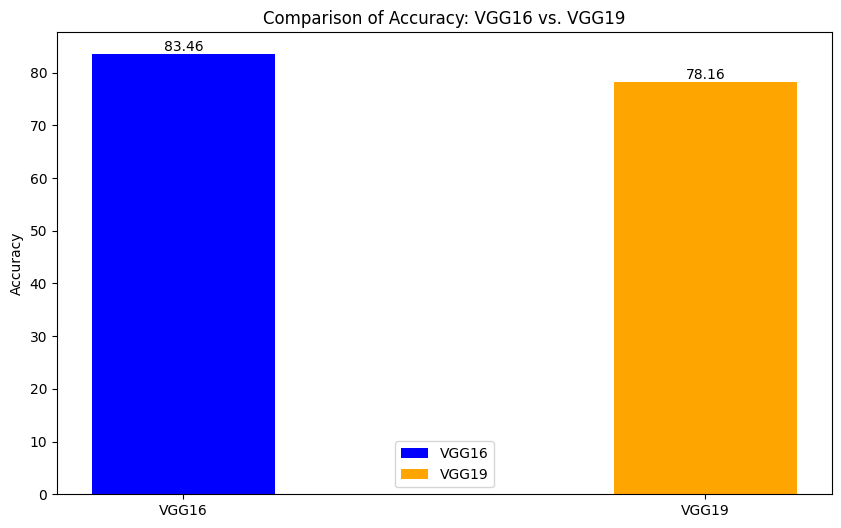

In [53]:
# loading VGG16 and VGG19 models
loss_1, vgg16_accuracy = loaded_vgg16model.evaluate(x_test, y_test)
loss_2, vgg19_accuracy = loaded_model.evaluate(x_test, y_test)
vgg16_accuracy = vgg16_accuracy * 100
vgg19_accuracy = vgg19_accuracy * 100

# Plot bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.35
bar_positions = np.arange(2)
bars = plt.bar(bar_positions, [vgg16_accuracy, vgg19_accuracy], bar_width, color=['blue', 'orange'], label=['VGG16', 'VGG19'])
# Annotate bars with exact accuracy values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Comparison of Accuracy: VGG16 vs. VGG19')
plt.ylabel('Accuracy')
plt.xticks(bar_positions, ['VGG16', 'VGG19'])
plt.legend()
plt.show()
